Loading and processing data

(1000, 200, 200)
(1000, 10)


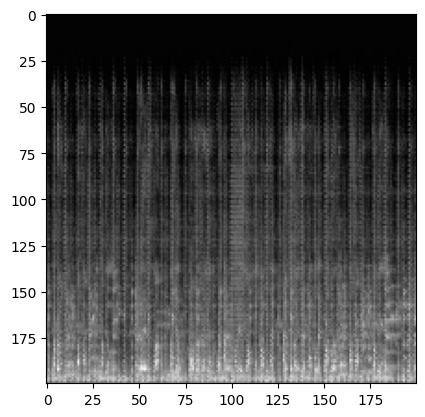

In [1]:
import numpy as np
from matplotlib import pyplot as plt

images = np.load("../data/processed/images.npy")
labels = np.load("../data/processed/labels.npy")
print(images.shape)
print(labels.shape)
input_shape = images.shape[1:]

plt.imshow(images[0], cmap="gray")
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test set
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Train set length:" + str(len(x_train)))
print("Test set length:" + str(len(y_test)))

Train set length:800
Test set length:200


Describing the model

In [15]:
import tensorflow
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

num_classes = 10
inputs = Input(shape=(input_shape + (1,))) # Nicer way to add this 1 as a dimension?

# lamda is the weight of the L2 penalty term
lamda = 0.25
L2_regularizer = keras.regularizers.l2(lamda)


# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = BatchNormalization()(inputs)
x = Conv2D(8, kernel_size=(5, 5), kernel_regularizer=L2_regularizer)(inputs)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(16, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(8, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = MaxPooling2D((4, 4))(x)
x = BatchNormalization()(x)
# x = Conv2D(32, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
# x = Activation('relu')(x)
# x = BatchNormalization()(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(32,kernel_regularizer=L2_regularizer)(encoded)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32,kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()
# ********************************************* Model ********************************************

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 196, 196, 8)       208       
                                                                 
 activation_9 (Activation)   (None, 196, 196, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 98, 98, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 98, 98, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 94, 94, 16)        3216

In [10]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.02, nesterov=True),
              metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10


2022-10-23 22:19:43.623993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 128000000 exceeds 10% of free system memory.


25/25 [==============================] - 10s 416ms/step - loss: 14.7462 - accuracy: 0.4588 - val_loss: 14.2690 - val_accuracy: 0.0650
Epoch 2/10
25/25 [==============================] - 10s 415ms/step - loss: 12.2397 - accuracy: 0.5138 - val_loss: 12.0900 - val_accuracy: 0.1450
Epoch 3/10
25/25 [==============================] - 11s 429ms/step - loss: 10.2516 - accuracy: 0.5375 - val_loss: 10.3191 - val_accuracy: 0.1150
Epoch 4/10
25/25 [==============================] - 11s 439ms/step - loss: 8.5837 - accuracy: 0.5825 - val_loss: 8.7929 - val_accuracy: 0.2000
Epoch 5/10
25/25 [==============================] - 11s 440ms/step - loss: 7.2034 - accuracy: 0.6075 - val_loss: 7.7350 - val_accuracy: 0.1750
Epoch 6/10
25/25 [==============================] - 11s 445ms/step - loss: 6.0555 - accuracy: 0.6600 - val_loss: 6.7984 - val_accuracy: 0.2300
Epoch 7/10
25/25 [==============================] - 12s 465ms/step - loss: 5.2912 - accuracy: 0.6100 - val_loss: 6.7597 - val_accuracy: 0.0650
Epoc

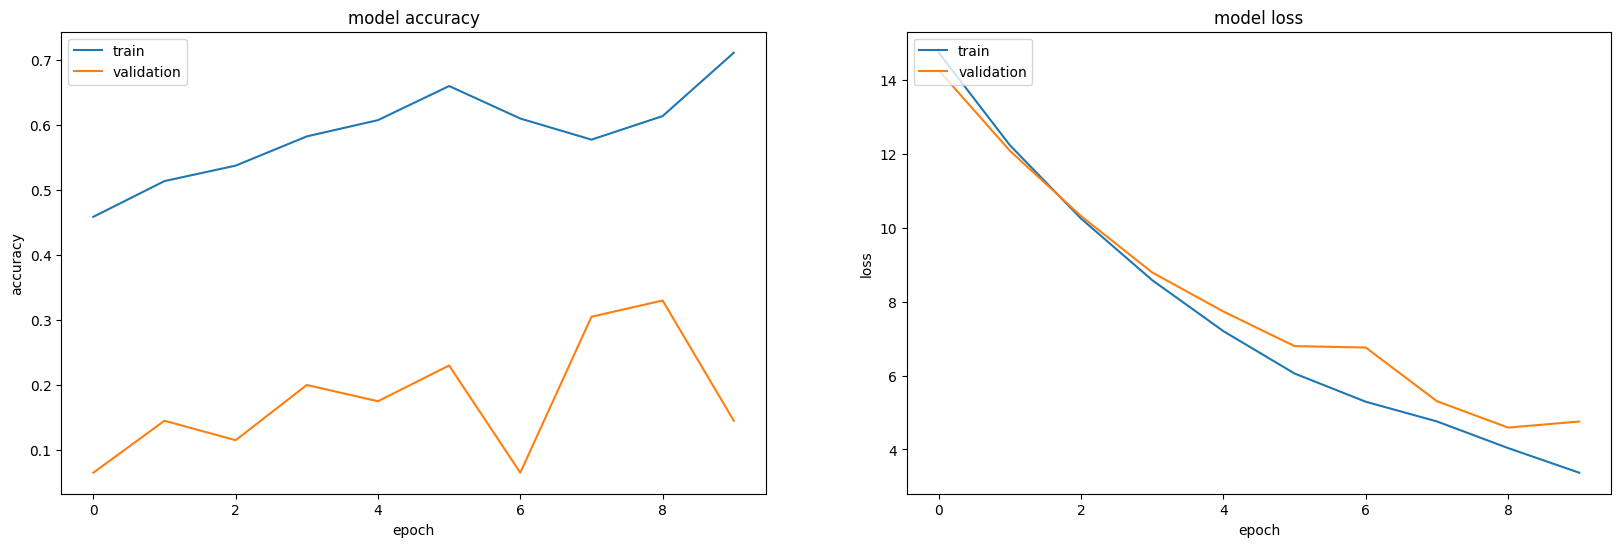

In [14]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

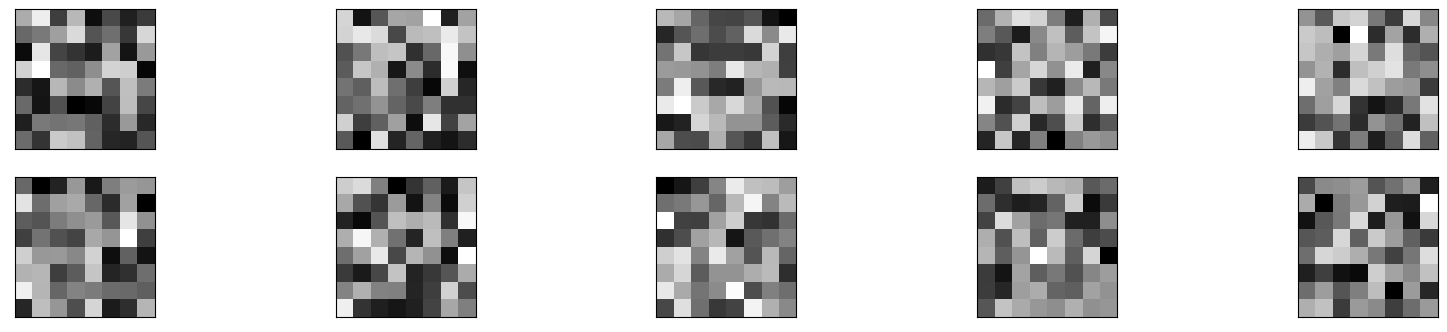

In [154]:
# Displaying the last weights
W = np.asarray(model.layers[-1].get_weights()[0])

W = W.reshape((8,8,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

In [169]:
predictions = model.predict(x_test)


def top1_error(preds,labels):
  return np.mean(np.argmax(preds,axis=1) != np.argmax(labels,axis=1))

print("Top-1 error is: " + str(top1_error(predictions,y_test[:len(predictions)])))


def top5_error(preds,labels):
  argsorted = np.argsort(np.argsort(preds,axis=1),axis=1)
  arg_of_1 = np.asarray(np.where(labels == 1))
  positions = argsorted[arg_of_1[0],arg_of_1[1]]
  num_of_wrong = np.count_nonzero(positions <= 4)
  return num_of_wrong / len(preds)

def top5_error_for_psychopaths(preds,labels):
  return np.count_nonzero(np.argsort(np.argsort(preds,axis=1),axis=1)[np.asarray(np.where(labels))[0],np.asarray(np.where(labels))[1]] <= 4) / len(preds)


print("Top-5 error is: " + str(top5_error_for_psychopaths(predictions,y_test[:len(predictions)])))

7/7 [==============================] - 2s 176ms/step
Top-1 error is: 0.835
Top-5 error is: 0.435
